In [96]:
using Pkg
if !haskey(Pkg.installed(), "Images") || !haskey(Pkg.installed(), "ImageMagick") || !haskey(Pkg.installed(), "FileIO") || !haskey(Pkg.installed(), "Glob")
    println("Installing required packages...")
    Pkg.add.(["Images", "ImageMagick", "FileIO", "Glob"])
end


using Plots
using LinearAlgebra
using GenericLinearAlgebra
using Images
using FileIO
using Glob
using ImageMagick  # pode ser necessário para JPEG


┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744


In [97]:
function complete_orthonormal(U::Matrix{Float64})
    d, r = size(U)
    r ≤ d || error("U deve ter no máximo d colunas")

    r == d && return zeros(Float64, d, 0)   # já completa

    # Projeta vetores aleatórios no complemento de span(U)
    Z = randn(Float64, d, d - r)
    Z .-= U * (U' * Z)                      # remove componente em U

    # QR fino garante ortonormalidade
    C = Matrix(qr(Z).Q)                  # d × (d−r)
    return C
end

complete_orthonormal (generic function with 1 method)

In [98]:
function build_csd_input_matrix(D1::Matrix{Float64}, D2::Matrix{Float64})
    # Dimensões
    m, d = size(D1)  # D1: m x d
    n, _ = size(D2)  # D2: n x d

    # Passo 1: QR de D1^T para obter base de R(D1) em R^d
    Q1 = Matrix(qr(D1').Q)  # Q1 é d x m
    R1 = Matrix(qr(D1').R)  # R1 é m x m

    println("Q1: ", size(Q1))  # Debugging: verificar tamanho de Q1
    println("R1: ", size(R1))  # Debugging: verificar tamanho de R1

    r1 = sum(abs.(diag(R1)) .> eps() * maximum(abs.(diag(R1))))  # Estimar posto
    E1 = Q1[:, 1:r1]  
    E2 = complete_orthonormal(E1)  # Base ortonormal completa para R^d, d x (d - r1)
    E = hcat(E1, E2)  # Base ortonormal completa para R^d, d x d
    
    # Passo 2: QR de D2^T para obter base de R(D2) em R^d
    Q2 = Matrix(qr(D2').Q)  # Q2 é d x n
    R2 = Matrix(qr(D2').R)  # R2 é n x n

    println("Q2: ", size(Q2))  # Debugging: verificar tamanho de Q2
    println("R2: ", size(R2))  # Debugging: verificar tamanho de R2

    c1 = sum(abs.(diag(R2)) .> eps() * maximum(abs.(diag(R2))))  # Estimar posto
    F1 = Q2[:, 1:c1]  
    F2 = complete_orthonormal(F1)  # Base ortonormal completa para R^d, d x (d - c1)
    

    # Passo 3: Calcular Q11 = E1^T F1
    Q11 = E1' * F1  # r1 x c1
    Q12 = E1' * F2  # r1 x (d - c1)
    Q21 = E2' * F1  # (d - r1) x c1
    Q22 = E2' * F2  # (d - r1) x (d - c1)

    # Passo 4: Concatenar Q11, Q12, Q21, Q22
    Qtop = hcat(Q11, Q12)
    Qbot = hcat(Q21, Q22)
    Q = vcat(Qtop, Qbot)
    
    return Q, r1, c1, E, E1, F1, R1, R2
end

build_csd_input_matrix (generic function with 1 method)

In [99]:
function rebuild_datasets_matrices(E, R)
    D_reconstructed = R' * E'  
    # Retornar a matriz reconstruída
    return D_reconstructed
end

rebuild_datasets_matrices (generic function with 1 method)

In [100]:
function verify_Q(Q::Matrix{Float64})
    if Q'*Q ≈ I
        println("A matriz Q é ortonormal")
    else
        println("A matriz Q não é ortonormal")
        
    end
end

verify_Q (generic function with 1 method)

In [101]:
function load_images_as_dataset(folder_path::String)
    # Lista todos os arquivos JPEG na pasta
    image_paths = Glob.glob("*.jpg", folder_path)
    num_images = min(length(image_paths), 100)  # Limita para no máximo 100 imagens

    if num_images == 0
        error("Nenhuma imagem encontrada na pasta.")
    end

    # Carrega uma imagem para obter dimensões
    img_sample = load(image_paths[1])
    img_gray = convert(Array{Gray{N0f8}}, img_sample)
    h, w = size(img_gray)

    println("Dimensões da imagem: $h x $w")

    # Inicializa matriz dataset
    dataset = zeros(Float64, num_images, h * w)

    for (i, path) in enumerate(image_paths[1:num_images])
        img = load(path)
        img_gray = convert(Array{Gray{N0f8}}, img)  # Converte para escala de cinza
        dataset[i, :] = vec(img_gray)  # Converte a imagem para vetor e armazena
    end

    return dataset, h, w
end



load_images_as_dataset (generic function with 1 method)

In [102]:
function reconstruct_image_from_vector(X::Matrix{Float64}, h::Int, w::Int, img_num::Int)
    vec_img = X[img_num, :]
    img_gray = reshape(vec_img, h, w)  # Reshape para a imagem em escala de cinza
    
    return img_gray
end


reconstruct_image_from_vector (generic function with 1 method)

In [103]:
#"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\Dataset PlayingCards\train\(card name)"

folder1 = raw"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\MNIST\trainingSet\trainingSet\1"
X, h, w = load_images_as_dataset(folder1)
size(X) 

Dimensões da imagem: 28 x 28


(100, 784)

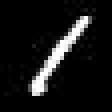

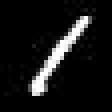

In [104]:
num = 0  # Número da imagem que você quer reconstruir
#se o folder contém "train", usa o formato com zeros à esquerda
#se não (se for "test"), usa o formato sem zeros à esquerda
img_path = (folder1 * "\\img_" * string(num) * ".jpg") 
img9 = load(img_path)
display(img9)
num = 1
img9_reconstruct= reconstruct_image_from_vector(X, h, w, num)
display(colorview(Gray, img9_reconstruct))

In [105]:
function display_image_grid(X::Matrix{Float64}, img_size::Tuple{Int,Int}, indices::Vector{Int}; grid_shape::Tuple{Int,Int}=nothing)
    n_imgs = length(indices)
    h, w = img_size

    # Define grid shape if not provided
    if grid_shape === nothing
        ncols = ceil(Int, sqrt(n_imgs))
        nrows = ceil(Int, n_imgs / ncols)
    else
        nrows, ncols = grid_shape
    end

    # Create empty canvas for each channel
    grid = zeros(Float64, nrows*h, ncols*w)

    n_pixels = h * w

    for (k, idx) in enumerate(indices)
        row = div(k-1, ncols)
        col = mod(k-1, ncols)
        img_gray =reconstruct_image_from_vector(X, h, w, idx)
        grid[(row*h+1):(row+1)*h, (col*w+1):(col+1)*w] .= img_gray

    end

    display(colorview(Gray, grid))
end


display_image_grid (generic function with 1 method)

In [106]:
function best_grid_shape(n_imgs::Int)
    # Procura divisores de n_imgs para formar um grid mais "quadrado" possível
    best_rows, best_cols = 1, n_imgs
    min_diff = n_imgs
    for rows in 1:floor(Int, sqrt(n_imgs))
        if n_imgs % rows == 0
            cols = div(n_imgs, rows)
            if abs(rows - cols) < min_diff
                best_rows, best_cols = rows, cols
                min_diff = abs(rows - cols)
            end
        end
    end
    # Se n_imgs é primo, usa aproximação quadrada
    if (best_rows == 1 || abs(best_rows - best_cols) > min(best_rows, best_cols)) && n_imgs > 10
        best_rows = floor(Int, sqrt(n_imgs))
        best_cols = ceil(Int, n_imgs / best_rows)
    end
    return best_rows, best_cols
end


best_grid_shape (generic function with 1 method)

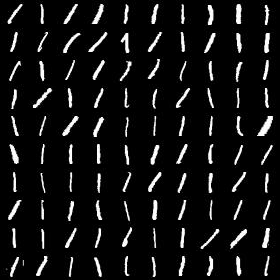

Número de imagens no dataset: 100
Número de linhas do grid: 10
Número de colunas do grid: 10


In [107]:
size_dataset = size(X, 1)
grid_rows, grid_cols = best_grid_shape(size_dataset)
println("Número de imagens no dataset: ", size_dataset)
println("Número de linhas do grid: ", grid_rows)
println("Número de colunas do grid: ", grid_cols)
display_image_grid(X, (h, w), collect(1:size_dataset); grid_shape=(grid_rows, grid_cols))

In [108]:
folder2 = raw"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\MNIST\trainingSet\trainingSet\7"
Y, h, w = load_images_as_dataset(folder2)
size(Y) 

Dimensões da imagem: 28 x 28


(100, 784)

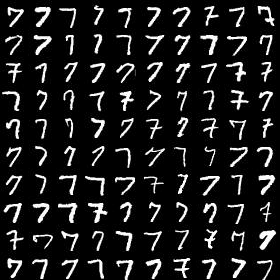

Número de imagens no dataset: 100
Número de linhas do grid: 10
Número de colunas do grid: 10


In [109]:

size_dataset = size(Y, 1)
grid_rows, grid_cols = best_grid_shape(size_dataset)
println("Número de imagens no dataset: ", size_dataset)
println("Número de linhas do grid: ", grid_rows)
println("Número de colunas do grid: ", grid_cols)
display_image_grid(Y, (h, w), collect(1:size_dataset); grid_shape=(grid_rows, grid_cols))

In [110]:
println("Tamanho do dataset X: ", size(X))
println("Tamanho do dataset Y: ", size(Y))
println("tamanho da imagem: ", h, " x ", w)


Tamanho do dataset X: (100, 784)
Tamanho do dataset Y: (100, 784)
tamanho da imagem: 28 x 28


In [111]:
# Exemplo de uso da função build_csd_input_matrix
Q, r1, c1, E, E1, F1, R1, R2 = build_csd_input_matrix(X, Y)

Q1: (784, 100)
R1: (100, 100)
Q2: (784, 100)
R2: (100, 100)


([0.14573002061967857 0.21008702134346535 … 0.020792588874254565 -0.029245888824217733; 0.2558079450150907 0.1769311997494752 … -0.006995246265538052 0.044350926239848064; … ; -0.018460291349156565 0.010774237316424263 … -0.019954831441828715 0.027453033407708057; 0.03758713577897972 0.00938487201047781 … -0.04101615167614996 0.04336117993209866], 100, 100, [0.0 7.112366251504909e-17 … -0.03788426756044815 0.009341069216477154; 0.0 0.0 … 0.011664755636457363 -0.014211503246620436; … ; 0.0 0.0 … 0.03507502691477683 -0.023099899206721366; 0.0 0.0 … -0.009643846467521885 0.016805249420611686], [0.0 7.112366251504909e-17 … -8.793870166725627e-18 -1.680105023802965e-15; 0.0 0.0 … 1.4115339139146972e-15 9.465691893528413e-16; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 1.717376241217039e-16 … 0.007603751384016034 -0.0009264354911417863; 0.0 0.0 … 0.005745488759910993 0.0038751815299404146; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-7.424107370062379 -1.804866577538724 … -2.321719328696

In [112]:
println(size(Q))  # Verifica o tamanho da matriz Q
println("Posto de D1: ", r1)
println("Posto de D2: ", c1)
println("Tamanho de E1: ", size(E1))  # Verifica o tamanho de E1
println("Tamanho de F1: ", size(F1))  # Verifica o tamanho de E2
println("Tamanho de R1: ", size(R1))  # Verifica o tamanho de R1
println("Tamanho de R2: ", size(R2))  # Verifica o tamanho de R2

(784, 784)
Posto de D1: 100
Posto de D2: 100
Tamanho de E1: (784, 100)
Tamanho de F1: (784, 100)
Tamanho de R1: (100, 100)
Tamanho de R2: (100, 100)


In [113]:
# Exibir e verificar a corretude da matriz A
verify_Q(Q)
X_reconstructed = rebuild_datasets_matrices(E1, R1)
Y_reconstructed = rebuild_datasets_matrices(F1, R2)

if X_reconstructed ≈ X && Y_reconstructed ≈ Y
    println("As matrizes reconstruídas são equivalentes às originais!")
else
    println("As matrizes reconstruídas NÃO são equivalentes às originais.")
        
end

A matriz Q é ortonormal
As matrizes reconstruídas são equivalentes às originais!


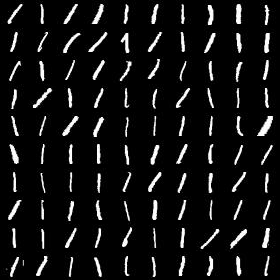

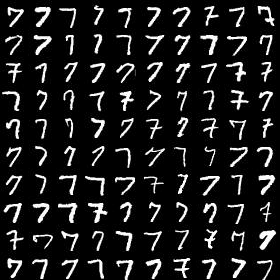

In [114]:
display_image_grid(X_reconstructed, (h, w), collect(1:size(X_reconstructed, 1)); grid_shape=(grid_rows, grid_cols))
display_image_grid(Y_reconstructed, (h, w), collect(1:size(Y_reconstructed, 1)); grid_shape=(grid_rows, grid_cols))

In [115]:
function csd(Q, c1, r1, E)
    d= size(Q, 1)  # Dimensão do espaço
    # separar Q em blocos
    Q11 = Q[1:r1, 1:c1]  # r1 x c1
    Q12 = Q[1:r1, c1+1:end]  # r1 x (d - c1)
    Q21 = Q[r1+1:end, 1:c1]  # ( d - r1) x c1
    Q22 = Q[r1+1:end, c1+1:end]  # (d - r1) x (d - c1)

    # SVD dos blocos de Q = EᵀF
    U1, S11, V1 = svd(Q11; full=true)     
    U2, S22, V2  = svd(Q22; full=true)

    D11 = U1' * Q11 * V1
    D12 = U1' * Q12 * V2 
    D21 = U2' * Q21 * V1
    D22 = U2' * Q22 * V2
    
    # Monta matriz diagonalizada D via blocos projetados
    D_top = hcat(D11, D12)  # r1 x d
    D_bot = hcat(D21, D22)  # (d - r1) x (d - c1)
    D = vcat(D_top, D_bot)  # d × d

    # Constrói matriz U unificada
    U = Matrix{Float64}(I, d, d)
    U[1:r1, 1:r1] = U1
    U[r1+1:end, r1+1:end] = U2
    
    # Constrói matriz V unificada
    V= Matrix{Float64}(I, d, d)
    V[1:c1, 1:c1] = V1
    V[c1+1:end, c1+1:end] = V2
    
    # Calcula os ângulos θ entre os subespaços
    θ = acos.(clamp.(S11, -1.0, 1.0))

    # Reconstrói a rotação W que leva E1 → F1
    W = E * U * D * U' * E'


    return U, U1, U2, V, V1, V2, D, θ, W  
end

csd (generic function with 1 method)

In [116]:
U, U1, U2, V, V1, V2, D, θ, W =csd(Q, c1, r1, E)

([-0.5556541898135907 -0.027177135518898055 … 0.0 0.0; -0.44417710544702815 0.20666792659979966 … 0.0 0.0; … ; 0.0 0.0 … 0.03346562029219789 -0.052399736049871415; 0.0 0.0 … 0.03810824591618229 0.030806649229897436], [-0.5556541898135907 -0.027177135518898055 … 0.0529499556406769 0.03863187256582331; -0.44417710544702815 0.20666792659979966 … 0.07450883155368168 -0.04556629052925388; … ; 0.01641994508368557 0.022428436921263877 … 0.005607659195045793 -0.11981956852101844; 0.018197997815417706 0.024670290844387 … -0.11073846459705236 -0.07615905886257579], [-0.014254553321785875 0.03642895260467341 … -0.05976850823005955 -0.030145643365495595; 0.0103642445588563 -0.05009784062942864 … -0.04671093984678815 0.03168271346521135; … ; -0.016567172368033636 -0.03973397287345373 … 0.03346562029219789 -0.052399736049871415; 0.06122697852824731 0.05571247169273162 … 0.03810824591618229 0.030806649229897436], [-0.24308857076896187 0.3375590576290888 … 0.0 0.0; -0.3943244383978991 0.12943608872810

In [117]:
display(θ)                 # Ângulos principais entre subespaços (em radianos)
@show(U*D*V' ≈ Q) 
display(norm(W-I) ≈ norm(D-I))  # Deve ser próximo de 0 (rotação direta correta)
@show W*E1*U1*V1' ≈ F1 

100-element Vector{Float64}:
 0.12033065257772292
 0.1801966034642833
 0.25871661780743405
 0.27090313556676887
 0.28371696354104137
 0.34441377751063024
 0.34927891897949864
 0.37574240430706934
 0.4005663253043163
 0.41066244668031987
 ⋮
 1.525551011947931
 1.5313889856086322
 1.5405814070181492
 1.5427238133464993
 1.5473033346045433
 1.5555582611589265
 1.5589373729813911
 1.5609603783454828
 1.5654549479379374

true

U * D * V' ≈ Q = true
W * E1 * U1 * V1' ≈ F1 = true


true

In [118]:
Y_reconstructed_from_rotation = rebuild_datasets_matrices(W*E1*U1*V1', R2)

if  Y_reconstructed_from_rotation ≈ Y
    println("A matriz Y reconstruída a partir da rotação de X é equivalente à original! :D")
else
    println("A matriz Y reconstruída a partir da rotação de X NÃO é equivalente à original. T-T")
end

A matriz Y reconstruída a partir da rotação de X é equivalente à original! :D


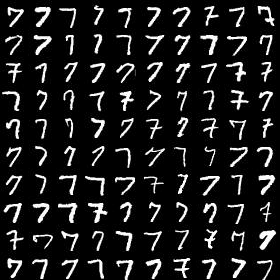

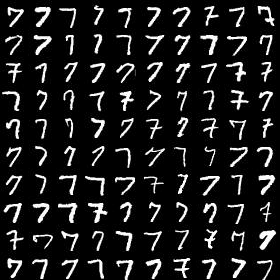

In [119]:
display_image_grid(Y_reconstructed_from_rotation, (h, w), collect(1:size(Y_reconstructed_from_rotation, 1)); grid_shape=(grid_rows, grid_cols))
display_image_grid(Y, (h, w), collect(1:size(Y, 1)); grid_shape=(grid_rows, grid_cols))

In [120]:
function smooth_transition(Q, c1, r1, E, R2)
    U, U1, U2, V, V1, V2, D, θ, W =csd(Q, c1, r1, E)
    max_angle= θ
    println("Máximo ângulo entre subespaços: ", max_angle)
    println("tamanho de max_angle" , size(max_angle))
    println("tamanho de D" , size(D))
    

    anim = @animate for angle in 0:1:max_angle
        println("Ângulo atual: ", angle)
        display(D)
        W = E * U * D * U' * E'
        Y_reconstructed_from_rotation = rebuild_datasets_matrices(W*E1*U1*V1', R2)
        display_image_grid(Y_reconstructed_from_rotation, (h, w), collect(1:size(Y_reconstructed_from_rotation, 1)); grid_shape=(grid_rows, grid_cols))
    end
    gif(anim, "smooth_transition.gif", fps = 10) # Save the animation as a GIF
end

smooth_transition (generic function with 3 methods)

In [121]:
smooth_transition(Q, c1, r1, E, R2)

Máximo ângulo entre subespaços: [0.12033065257772292, 0.1801966034642833, 0.25871661780743405, 0.27090313556676887, 0.28371696354104137, 0.34441377751063024, 0.34927891897949864, 0.37574240430706934, 0.4005663253043163, 0.41066244668031987, 0.4444104044467178, 0.45557201773325057, 0.49974669968038765, 0.5132272680351526, 0.5370873894192305, 0.5503164681196484, 0.552677240623906, 0.585472027808286, 0.5899545479971188, 0.6237521249854392, 0.6399862032122492, 0.6470287173971453, 0.6687729747130273, 0.6921313736701745, 0.7080190216139931, 0.7337530091387613, 0.738417976211527, 0.7571162931719794, 0.7667484059066146, 0.798703614366135, 0.8161012926523777, 0.8200271740213207, 0.8408788155083555, 0.8502221652273865, 0.8627113549677148, 0.8732823779766352, 0.8889487495477045, 0.9097840782583958, 0.92886010755948, 0.9420266458055134, 0.9671973710427648, 0.9817831388001679, 0.9951591075025543, 1.0215172355172628, 1.0249331140124227, 1.0336537942338673, 1.0449775075502958, 1.0547434164276561, 1.0

MethodError: MethodError: no method matching (::Colon)(::Int64, ::Int64, ::Vector{Float64})

Closest candidates are:
  (::Colon)(::T, ::T, !Matched::T) where T<:Real
   @ Base range.jl:22
  (::Colon)(::T, ::Any, !Matched::T) where T<:Real
   @ Base range.jl:50
  (::Colon)(::T, ::T) where T<:Real
   @ Base range.jl:5
  ...
